In [1]:
#!pip install pygad

Modified version of pygad samples. https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad <br>
Model inspired and modified from http://uhurumkate.blogspot.com/2018/06/tiny-model-for-mnist-dataset.html

You're highly encouraged to use a GPU as it's going to spent most resources on predicting and calculating acc. Please also note that pygad library only use CPU paralleal in some cases.

The highest acc was achieved with everything set to False, and with 23 hours of training. 500 cycles and 58% acc

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import losses, datasets, layers, optimizers, Sequential, metrics
import pygad.kerasga
import numpy
import math
import pygad

from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
model = tensorflow.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None, input_tensor=None,
    input_shape=(32,32,1), pooling=None, classes=10)

2021-12-10 08:11:55.499500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-10 08:11:55.555641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-10 08:11:55.556399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-10 08:11:55.557629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFl

# Hyper param

In [4]:
acc_meter = tf.keras.metrics.Accuracy()

#Instead of training a entire dataset, do small batches.
sgd_like = True

#introduce new population when stucked. Often time it'll stuck in local optima.
introduce_new_pop = False

#increase batch size when stcuked.
dynamic_batch_size = True

#reshuffle
reshuffle = True

In [5]:
#num cycles
num_generations = 10000

#num soltions
num_solution= 7

#the following two param only works if introduce_new_pop = True
#Maxium cycles stuck before introducing new population to the pool.
max_cycles_stucked = 20

#The follow two param have effect only when sgd_like = True
#number of cycles you want on a single batch. 
epoch = 5
#number of samples per batch
batch_size = 64

#number batch increase feed into prediction. only have effect if sgd_like = True
#Ex. batch size 1500 -> 1500 + 500 = 2000. Note that some data will be lose during the process
batch_increase = 1024

#reshuffle every n cycles
reshuffle_per = (int(60000/batch_size) -1) * epoch #so that it's insync with epoch

decay = 1000

#Typical pygad params
num_parents_mating = int(num_solution * .5) #half parents mating
parent_selection_type = "sss"
mutation_type="adaptive"
mutation_lower = 89
mutation_num_genes=(90, mutation_lower)
keep_parents = 0

# dataset

In [6]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
#normalize data
X_train = 2*tf.convert_to_tensor(X_train, tf.float32)/255.-1
#[b, 28, 28] -> [b, 28, 28, 1]
X_train = tf.reshape(X_train, (-1, 28,28,1))
X_test = 2*tf.convert_to_tensor(X_test, tf.float32)/255.-1
X_test = tf.reshape(X_test, (-1, 28,28,1))
y_train = tf.convert_to_tensor(y_train, tf.int32)
#[b] -> [b, 10]
y_train = tf.one_hot(y_train, 10)
y_test = tf.convert_to_tensor(y_test, tf.int32)
y_test = tf.one_hot(y_test, 10)

In [7]:
X_train = tf.image.resize(X_train, (32,32))
X_test = tf.image.resize(X_test, (32,32))

In [8]:
#numpy.reshape(X_train[0], (32,32))

In [9]:
import matplotlib.pyplot as plt

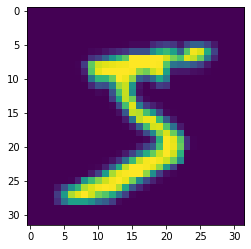

In [10]:
plt.imshow(numpy.reshape(X_train[0], (32,32)))
plt.show()

# Model

We want a very small model for the increase in param will increase the cycles GA needs to run </ba>
Model parameter = 2665 with acc ~ 96% on both train/testing sets (trained with triditional method).<br>
EDIT: <br>
 I relized that the model **DO** have impact. For example, when l`ayers.Dense(3, activation='relu')`, you'll have 1.8k param. You might think it'll be easier for the model to converge. Yet, `layers.Dense(10, activation='relu')` is faster. `layers.Dense(20, activation='relu')` is even better with 4.5k param. This indicates we don't need a small model, but a GOOD model (define good).

model = Sequential([
#input layer
layers.Convolution2D(15, (3, 3), activation='relu', input_shape=(28,28,1)),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
layers.AveragePooling2D(2),
#convo layers1
layers.Convolution2D(10,(1,1), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers2
layers.AveragePooling2D(2),
layers.Convolution2D(5,(3,3), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers3
layers.Convolution2D(10,(1,1), activation='relu'),
layers.Dropout(0.1),
#fully connected layer1
layers.Dense(64, activation='relu'),
layers.Dense(32, activation='relu'),
layers.Flatten(),
#output layer
layers.Dense(10, activation='softmax')
])

model.summary()

maybe FCNN do better?

model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(28,28,1)),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

model.summary()

def weighted_f1_loss(y_true, y_pred, num_class=10):
    #create confusion matrix
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    cm = tf.math.confusion_matrix(y_pred,y_true, num_class)
    #sum true positive
    tp = tf.math.reduce_sum(cm * tf.eye(num_class, dtype='int32'), 0)
    #recall score
    rc = tp/tf.math.reduce_sum(cm, 0)
    #precision score
    pr = tf.math.reduce_sum(cm * tf.eye(num_class, dtype='int32'), 1)
    pr = pr / tf.math.reduce_sum(cm, 1)
    #f1
    f1 = 2 * (pr * rc)/(pr + rc)
    #weighted f1
    wf1 = tf.cast(tf.math.reduce_sum(cm, 0), 'float64') * f1
    wf1 = tf.math.reduce_sum(tf.boolean_mask(wf1, tf.math.is_finite(wf1)))/len(y_true)
    #GA works best when given direction -> ** 2
    return wf1 ** 2

def some_loss(y_true, y_pred):
  return tf.reduce_sum(y_true*(tf.math.exp(tf.math.abs(y_pred -y_true))-1)) /len(y_true)

def some_loss(y_true, y_pred):
  pt1 = tf.where(y_true == 0, 1E-6, y_true)
  return tf.reduce_sum(tf.math.abs(y_pred - pt1)) ** 2

In [11]:
def some_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.exp(y_pred - y_true)) ** 2

In [12]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
def some_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.abs(y_pred - y_true))

In [14]:
acc_meter.update_state(tf.argmax(model(X_test[:1000], training=False), axis=1), tf.argmax(y_test[:1000], axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model(X_train[:1000], training=False), axis=1), tf.argmax(y_train[:1000], axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

2021-12-10 08:11:58.676141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-12-10 08:11:59.729099: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Accuracy on testing set:11.59999966621399%
Error rate on testing set:88.40000033378601%
Accuracy on training set:10.80000028014183%
Error rate on training set:89.19999971985817%


loss

In [15]:
#we don't need one-hot to train it's for tf.fit(). To compute tf.argmax each loop is a waste of resources
#y_train = tf.argmax(y_train, axis=1)

Perpare batches if we were doing SGD-like method. <br>
Some data are removed if size of dataset / batch_size is not an integer

In [16]:
#A method always modifing X_train_sgd and y_train_sgd
def make_batch(batch_size):
  idx = numpy.random.permutation(len(X_train))
  global X_train_sgd, y_train_sgd
  if len(X_train) % batch_size == 0:
    X_train_sgd = tf.reshape(X_train.numpy()[idx], [-1, batch_size, 32, 32, 1])
    y_train_sgd = tf.reshape(y_train.numpy()[idx], [-1, batch_size, 10])
  else:
    #Remove some samples if can't rehape 
    len_remove = len(X_train) % batch_size
    X_train_sgd = tf.reshape(X_train.numpy()[idx][:-len_remove], [-1, batch_size, 32, 32, 1])
    y_train_sgd = tf.reshape(y_train.numpy()[idx][:-len_remove], [-1, batch_size, 10])

In [17]:
def lsm(arr):
    x = numpy.arange(len(arr))
    n = len(arr)
    pt1 = (n * numpy.sum(arr * x)) - (numpy.sum(x)*numpy.sum(arr))
    pt2 = n * numpy.sum(x ** 2) - (numpy.sum(x)**2)
    m = pt1 / pt2
    b = (numpy.sum(arr) - (m*numpy.sum(x))) / n
    print(m)
    return m * x + b

In [18]:
import matplotlib.pyplot as plt

In [19]:
X_train_sgd = []
y_train_sgd = []
make_batch(batch_size)

# Fitness 

In [ ]:
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=num_solution)

In [ ]:
#Some helper varibles
i = 0
cycles_stucked = 0
k=0
tmp = 0

#fitness_func uses acc matrix as fitness.
def fitness_func(solution, sol_idx):

    global model, i, cycles_stucked ,X_train, y_train, k, y_train_sgd, X_train_sgd
    solution_fitness = 0
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    #if perfer to use loss instead
    #solution_fitness = 1/cce(model.predict(X_train), y_train).numpy()

    if sgd_like == True:
      #update acc_meter
      #acc_meter.update_state(tf.argmax(model.predict(X_train_sgd[k]), axis=1), y_train_sgd[k])
      #solution_fitness = acc_meter.result().numpy() * 100
      #acc_meter.reset_states()
      solution_fitness = some_loss(model(X_train_sgd[k], training=False), y_train_sgd[k]).numpy()
    else:
      #acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
      #solution_fitness = acc_meter.result().numpy() * 100
      #acc_meter.reset_states()
      solution_fitness = some_loss(model(X_train, training=False), y_train).numpy()
    #print(solution_fitness)
    if numpy.isnan(solution_fitness):
      return 1E-20
    else:
      return 1/ solution_fitness

# Crossover function

In [ ]:
def crossover_func(parents, offspring_size, ga_instance):
  global cycles_stucked
  offspring = []
  idx = 0

  #Standard offspring method from https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad
  while len(offspring) != offspring_size[0]:
    parent1 = parents[idx % parents.shape[0], :].copy()
    parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
    random_split_point = numpy.random.choice(range(offspring_size[0]))
    parent1[random_split_point:] = parent2[random_split_point:]
    offspring.append(parent1)
    idx += 1

  offspring = numpy.array(offspring)
  
  if introduce_new_pop and cycles_stucked == max_cycles_stucked:
    #craete new parents with new random variables
    new_parents = tf.random.truncated_normal(offspring.shape).numpy()
    #create an array that contain both offspring and new parents
    new_parents = numpy.append(new_parents, offspring)
    #shuffle
    numpy.random.shuffle(new_parents)
    #rehspae
    new_parents = new_parents.reshape(-1, offspring.shape[1])
    offspring = new_parents[:len(offspring)]
    print('New gene added')
    #Only want to do this once
    cycles_stucked = 0

  return numpy.array(offspring)

# callback

In [ ]:
def callback_generation(ga_instance):
    global i, k, cycles_stucked, tmp, X_train_sgd, mutation_lower, decay, epoch
    
    fitness = ga_instance.best_solution()[1]
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=fitness))

    if fitness == tmp:
      cycles_stucked += 1
      if dynamic_batch_size and cycles_stucked == max_cycles_stucked:
        #increase batch size. Up until only 1 batch with all samples avaliable
        make_batch(min(X_train_sgd.shape[1]+batch_increase, X_train_sgd.shape[0]*X_train_sgd.shape[1]))
        print("Batch size increased -> new shape: ",X_train_sgd.shape)
        k = numpy.random.randint(0, len(X_train_sgd)-1)
        #Otherwise introduce_new_pop from cross over will never be True. 
        if not introduce_new_pop:
          #keep track of cycles stucked
          cycles_stucked = 0
    else:
      cycles_stucked = 0

    #keep track of generation
    i += 1
    if sgd_like == True:
      if i % (1 * epoch) == 0:
        #select random data from reshaped dataset to train
        k = numpy.random.randint(0, len(X_train_sgd)-1)
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print('new set')
    if reshuffle:
      if i % (1 * reshuffle_per) == 0:
        #select random data from reshaped dataset to train
        make_batch(X_train_sgd.shape[1])
        print('reshuffled')
    #update tmp
    tmp = fitness
    
    if i % (decay) == 0:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=fitness))
        mutation_lower -= 15
        #epoch += 10 
        setattr(ga_instance, 'mutation_num_genes', (90, max(5, mutation_lower)))
        #make_batch(max(X_train_sgd.shape[1]-batch_increase, 500))
        #k = numpy.random.randint(0, len(X_train_sgd)-1)
        #decay = max(decay - 50, 100)
        print("Batch size increased -> new shape: ",X_train_sgd.shape)
        print("new mutation rate:", max(30, mutation_lower), " decay: ", decay)
#    if fitness >= 50:
#      sgd_like = True

#  Run

In [ ]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
# Use the pre-existing model weight as init population. 
initial_population = numpy.tile(pygad.kerasga.model_weights_as_vector(model), (num_solution, 1))


ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_func,
                       mutation_num_genes=mutation_num_genes,
                       on_generation=callback_generation)
                       #stop_criteria='reach_85')

ga_instance.run()

# Stat

In [ ]:

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)

#remove if using acc matrix as fitness instead])
#acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
#print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
#print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

#acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
#print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
#print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

In [ ]:
acc_meter.update_state(tf.argmax(model(X_test[:1000], training=False), axis=1), tf.argmax(y_test[:1000], axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model(X_train[:1000], training=False), axis=1), tf.argmax(y_train[:1000], axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

In [ ]:
arr = getattr(ga_instance, 'best_solutions_fitness')
x = numpy.arange(len(arr))

In [ ]:
plt.plot(x, arr)
per = 500
i = 0
j = i + per
while j <= len(arr):
    plt.plot(x[i:j], lsm(arr[i:j]), 'yellow')
    i = j
    j += per